# Precursor mass differences

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

import reader
import util

In [3]:
tqdm.tqdm = tqdm.tqdm_notebook

# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')

In [4]:
max_fdr = 0.01
tol_mass = 0.1
tol_mode = 'Da'

In [5]:
psms_dir = '../data/processed/hek293/ann-solo/oms'

In [6]:
psms = []
for filename in tqdm.tqdm(os.listdir(os.path.join(psms_dir)),
                          'Files processed', unit='files'):
    if filename.endswith('.mztab'):
        psms.append(util.filter_group_fdr(
            reader.read_mztab_psms(os.path.join(psms_dir, filename)),
            max_fdr, tol_mass, tol_mode))

psms = pd.concat(psms)

HBox(children=(IntProgress(value=0, description='Files processed: ', max=48), HTML(value='')))

/Users/Wout/.conda/envs/ann-solo/lib/python3.6/site-packages/pyteomics/auxiliary.py:661: RuntimeWarning: divide by zero encountered in true_divide
  q = tfalse / (ind - cumsum) / ratio


In [7]:
psms['mass_diff'] = (
    (psms['exp_mass_to_charge'] - psms['calc_mass_to_charge']) * psms['charge']
)

In [8]:
mass_diff_groups = []
psms_remaining = psms.sort_values('search_engine_score[1]', ascending=False)
while len(psms_remaining) > 0:
    mass_diff = psms_remaining['mass_diff'].iloc[0]
    psms_selected = psms_remaining[
        (psms_remaining['mass_diff'] - mass_diff).abs() <= tol_mass]
    psms_remaining = psms_remaining.drop(psms_selected.index)
    mass_diff_groups.append((psms_selected['mass_diff'].median(),
                             len(psms_selected)))
mass_diff_groups = pd.DataFrame.from_records(mass_diff_groups,
                                             columns=['mass_diff', 'num_psms'])

In [9]:
mass_diff_groups.sort_values('num_psms', ascending=False).head(10)

,mass_diff,num_psms
0,0.002714,272947
2,1.005141,50433
1,15.997934,34090
10,2.003027,14617
62,-43.002912,11946
26,-17.023188,5939
42,27.998368,5462
11,17.001957,5340
12,-1.047402,5178
197,183.038685,4862


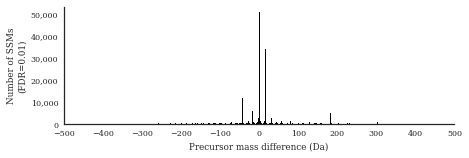

In [10]:
width = 7
height = width / 1.618 / 2
fig, ax = plt.subplots(figsize=(width, height))

mask = mass_diff_groups['mass_diff'].abs() > tol_mass
ax.bar(mass_diff_groups[mask]['mass_diff'],
       mass_diff_groups[mask]['num_psms'],
       width=1, log=False, color='black')

ax.set_xlabel('Precursor mass difference (Da)')
ax.set_ylabel('Number of SSMs\n(FDR={})'.format(max_fdr))

ax.set_xlim((-500, 500))

# set tick labels at nice positions
ax.xaxis.set_major_locator(mticker.MultipleLocator(100))
# format y-axis numbers
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,g}'))

sns.despine()

plt.savefig('mass_diff.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()